# Incorporate clutter by making use of Corine Land Cover survey

## License

```
Working with Corine land cover data.
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import os
from pathlib import Path
import zipfile
from zipfile import ZipFile
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from scipy.interpolate import RegularGridInterpolator
from pycraf import conversions as cnv
from pycraf import protection, pathprof, geometry, geospatial
from astropy import units as u
from IPython.display import display

pjoin = os.path.join

To use this notebook, you need to download a Corine Land Cover dataset from the following URL: https://land.copernicus.eu/pan-european/corine-land-cover/. The following assumes that the 2018 version was downloaded, but of course the notebook would also work with other versions (just change the file names accordingly). Note that you need to create an account on the webpage, before you can retrieve the data.

In [3]:
CORINE_PATH = Path('.')  # specify path to Corine data, if not local to notebook
CORINE_ZIPFILE = CORINE_PATH / Path('clc2018_clc2018_v2018_20_raster100m.zip')

Rasterio allows us to read the Geotiff directly from the zip-file:

In [4]:
CORINE_GEOTIFF = (
    'zip+file://{:s}'
    '!'
    'clc2018_clc2018_v2018_20_raster100m/CLC2018_CLC2018_V2018_20.tif'.format(
        str(CORINE_ZIPFILE)
        ))


In [5]:
CORINE_GEOTIFF

'zip+file://clc2018_clc2018_v2018_20_raster100m.zip!clc2018_clc2018_v2018_20_raster100m/CLC2018_CLC2018_V2018_20.tif'

In [6]:
corine_geotiff = rio.open(CORINE_GEOTIFF)

However, we also want to make use of the color legend provided in a QGIS legend file within the zip-file. 

In [7]:
with ZipFile(CORINE_ZIPFILE, 'r') as zip:
    CORINE_CMAP = zip.extract(
        'clc2018_clc2018_v2018_20_raster100m/Legend/'
        'CLC2018_CLC2018_V2018_20_QGIS.txt',
        path=CORINE_PATH,
        )

In [8]:
CORINE_CMAP

'clc2018_clc2018_v2018_20_raster100m/Legend/CLC2018_CLC2018_V2018_20_QGIS.txt'

In [9]:
cmap_qgis = np.genfromtxt(
    CORINE_CMAP, delimiter=',',
    dtype=np.dtype([
        ('Code', np.uint16),
        ('R', np.uint8),
        ('G', np.uint8),
        ('B', np.uint8),
        ('A', np.uint8),
        ('Description', np.str, 100),
    ]))

The color legend contains the Corine class IDs along with RGBA tuples (colors) and a comment that explains the meaning of the ID.

In [10]:
cmap_qgis

array([(111, 230,   0,  77, 255, 'Continuous urban fabric'),
       (112, 255,   0,   0, 255, 'Discontinuous urban fabric'),
       (121, 204,  77, 242, 255, 'Industrial or commercial units'),
       (122, 204,   0,   0, 255, 'Road and rail networks and associated land'),
       (123, 230, 204, 204, 255, 'Port areas'),
       (124, 230, 204, 230, 255, 'Airports'),
       (131, 166,   0, 204, 255, 'Mineral extraction sites'),
       (132, 166,  77,   0, 255, 'Dump sites'),
       (133, 255,  77, 255, 255, 'Construction sites'),
       (141, 255, 166, 255, 255, 'Green urban areas'),
       (142, 255, 230, 255, 255, 'Sport and leisure facilities'),
       (211, 255, 255, 168, 255, 'Non-irrigated arable land'),
       (212, 255, 255,   0, 255, 'Permanently irrigated land'),
       (213, 230, 230,   0, 255, 'Rice fields'),
       (221, 230, 128,   0, 255, 'Vineyards'),
       (222, 242, 166,  77, 255, 'Fruit trees and berry plantations'),
       (223, 230, 166,   0, 255, 'Olive groves'),
  

Geotiff files have meta information attached to the data array, which contain, e.g., the geographical frame, bounds or data types:

In [11]:
corine_geotiff.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 65000,
 'height': 46000,
 'count': 1,
 'crs': CRS.from_epsg(3035),
 'transform': Affine(100.0, 0.0, 900000.0,
        0.0, -100.0, 5500000.0)}

That dataset seems to contain a huge map! (All of Europe with 100 m pixel size...). Plotting this would take very long. Therefore, we will read a subset of the data, only. See below.

In [12]:
corine_geotiff.bounds

BoundingBox(left=900000.0, bottom=900000.0, right=7400000.0, top=5500000.0)

In [13]:
corine_geotiff.tags(ns='IMAGE_STRUCTURE')

{'COMPRESSION': 'LZW', 'INTERLEAVE': 'BAND'}

In [14]:
corine_geotiff.crs.data  # the CRS will be useful later to extract proper world coordinates

{'init': 'epsg:3035'}

In [15]:
corine_geotiff.dtypes

('int16',)

In [16]:
corine_geotiff.nodatavals

(-32768.0,)

A Geotiff can have more than one map included, so-called "bands". The number of bands included can be retrieved like this:

In [17]:
corine_geotiff.count, corine_geotiff.indexes

(1, (1,))

Reading from a certain band is easy:

In [18]:
# WARNING, if you don't have a decent amount of RAM, don't run the following line...
# corine_data = corine_geotiff.read(1)

#  ... but instead apply a window to read only a subset of the data:
window = rio.windows.Window(20000, 15000, 10000, 10000)
corine_data = corine_geotiff.read(1, window=window)

(For GeoTiff files with more than one band, it is also possible to read-in all bands at once, producing a 3D array.)

Some maps also have a mask array:

In [19]:
# corine_geotiff.dataset_mask()

In [20]:
corine_data.shape

(10000, 10000)

First, we need to create a proper colorbar for use with matplotlib. With a "ListedColormap" we can achieve the desired results. The tricky part is that the Corine class IDs are not consecutive. Some "magic" is necessary to have the ticks appear in the middle of each color box.

In [21]:
cmap = matplotlib.colors.ListedColormap(
    np.array(cmap_qgis[['R', 'G', 'B', 'A']].tolist()) / 255.
    )
cmap.set_under('1.0')
tmp = np.hstack([0, cmap_qgis['Code'], 10000])
bounds = 0.5 * (tmp[:-1] + tmp[1:])
cticks = 0.5 * (bounds[:-1] + bounds[1:])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

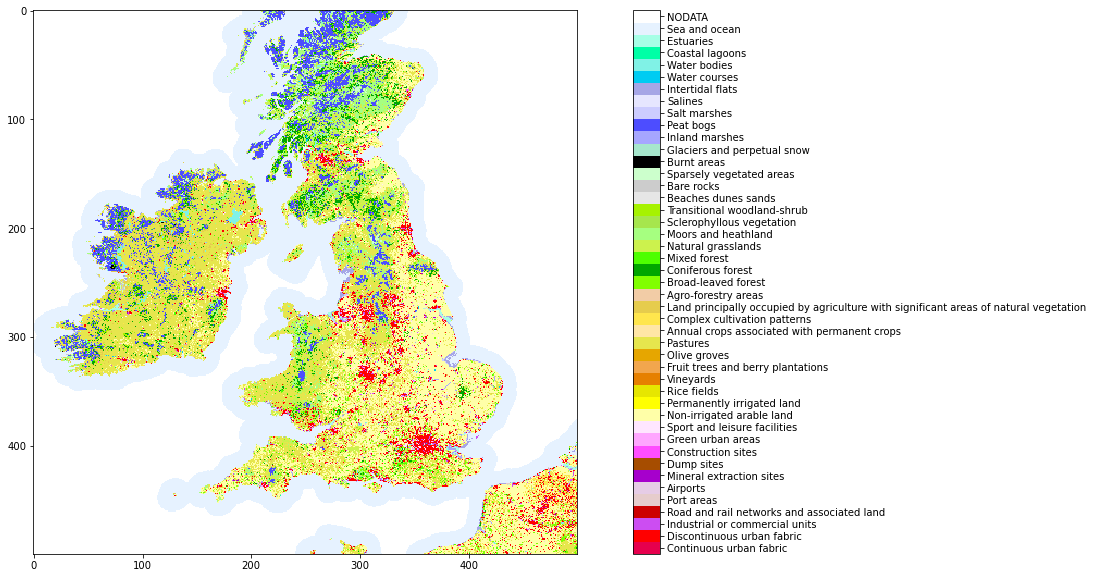

In [22]:
plt.close()
fig = plt.figure(figsize=(20, 10))
plt.imshow(
    corine_data[::20, ::20], origin='upper', cmap=cmap, norm=norm, 
    interpolation='nearest',
    )
cbar = plt.colorbar()
cbar.set_ticks(cticks)
cbar.ax.set_yticklabels(cmap_qgis['Description'], color='k')
plt.show()

In order to use this for [Rec. ITU-R P.452]() clutter calculations, we need to define a map between Corine IDs and P.452 Clutter classes. The following classes are defined in P.452/pycraf:

In [23]:
pathprof.CLUTTER_NAMES

['UNKNOWN',
 'SPARSE',
 'VILLAGE',
 'DECIDIOUS_TREES',
 'CONIFEROUS_TREES',
 'TROPICAL_FOREST',
 'SUBURBAN',
 'DENSE_SUBURBAN',
 'URBAN',
 'DENSE_URBAN',
 'HIGH_URBAN',
 'INDUSTRIAL_ZONE']

For now, we use the following map between the two:

In [24]:
pathprof.CORINE_TO_P452_CLASSES

{111: 'URBAN',
 112: 'SUBURBAN',
 121: 'INDUSTRIAL_ZONE',
 122: 'INDUSTRIAL_ZONE',
 123: 'INDUSTRIAL_ZONE',
 124: 'INDUSTRIAL_ZONE',
 131: 'INDUSTRIAL_ZONE',
 132: 'INDUSTRIAL_ZONE',
 133: 'INDUSTRIAL_ZONE',
 141: 'URBAN',
 142: 'INDUSTRIAL_ZONE',
 211: 'SPARSE',
 212: 'SPARSE',
 213: 'SPARSE',
 221: 'SPARSE',
 222: 'SPARSE',
 223: 'SPARSE',
 231: 'SPARSE',
 241: 'SPARSE',
 242: 'SPARSE',
 243: 'SPARSE',
 244: 'SPARSE',
 311: 'DECIDIOUS_TREES',
 312: 'CONIFEROUS_TREES',
 313: 'DECIDIOUS_TREES',
 321: 'SPARSE',
 322: 'SPARSE',
 323: 'SPARSE',
 324: 'SPARSE',
 331: 'SPARSE',
 332: 'SPARSE',
 333: 'SPARSE',
 334: 'SPARSE',
 335: 'SPARSE',
 411: 'UNKNOWN',
 412: 'UNKNOWN',
 421: 'UNKNOWN',
 422: 'UNKNOWN',
 423: 'UNKNOWN',
 511: 'UNKNOWN',
 512: 'UNKNOWN',
 521: 'UNKNOWN',
 522: 'UNKNOWN',
 523: 'UNKNOWN'}

For plotting, pycraf has some pre-defined colors for each P.452 class (you could replace this with your own scheme of course):

In [25]:
pathprof.P452_CLUTTER_COLORS

{'UNKNOWN': (255, 255, 255, 0),
 'SPARSE': (255, 230, 200, 255),
 'VILLAGE': (255, 160, 50, 255),
 'DECIDIOUS_TREES': (128, 255, 0, 255),
 'CONIFEROUS_TREES': (0, 166, 0, 255),
 'TROPICAL_FOREST': (166, 230, 77, 255),
 'SUBURBAN': (255, 100, 0, 255),
 'DENSE_SUBURBAN': (255, 100, 50, 255),
 'URBAN': (255, 0, 0, 255),
 'DENSE_URBAN': (255, 0, 50, 255),
 'HIGH_URBAN': (255, 0, 100, 255),
 'INDUSTRIAL_ZONE': (255, 255, 0, 255)}

The full Corine data set is too large to handle it on a normal PC. Let's use a subset of the data, a region around Denmark:

In [26]:
window = rio.windows.Window(33500, 18000, 3000, 3000)
corine_data = corine_geotiff.read(1, window=window)
# for the sake of demonstration, we'll work only on every 10th pixel
corine_data_sub = corine_data[::10, ::10]

Now, we can translate from one to the other, using a function in the pycraf.pathprof sub-package:

In [27]:
clutter_data = pathprof.landcover_to_p452_clutter_zones(corine_data_sub, pathprof.CORINE_TO_P452_CLASSES)

This function, basically does the following:

In [28]:
# clutter_data = np.full(corine_data_sub.shape, -1, dtype=np.int8)
# for cor_id, cl_name in pathprof.CORINE_TO_P452_CLASSES.items():
#     mask = corine_data_sub == cor_id
#     clutter_data[mask] = getattr(pathprof.CLUTTER, cl_name)

And again, we need to define a nice color map for matplotlib:

In [29]:
cmap = matplotlib.colors.ListedColormap(
    np.array(list(pathprof.P452_CLUTTER_COLORS.values())) / 255.
    )
cmap.set_under('1.0')
bounds = np.arange(-1.5, 10.6, 1)
ticks = np.arange(-1, 10.6, 1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

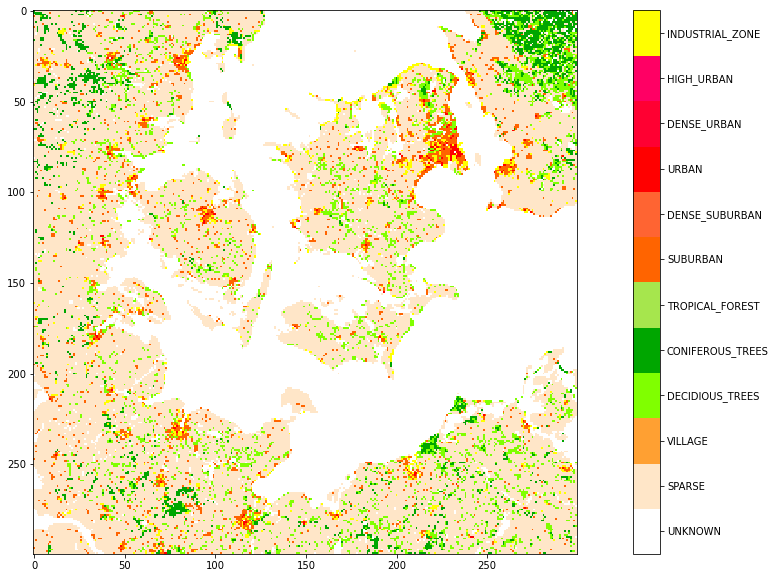

In [30]:
plt.close()
fig = plt.figure(figsize=(20, 10))
plt.imshow(
    clutter_data, origin='upper', cmap=cmap, norm=norm, interpolation='nearest',
    )
cbar = plt.colorbar()
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(pathprof.P452_CLUTTER_COLORS, color='k')
plt.show()

For pycraf path propagation calculations, we need the clutter classes on the grid defined by the topographical data (e.g. SRTM). This makes a reprojection of the data necessary. As mentioned before, Geotiff files contain information about the geographical frame:

In [31]:
corine_geotiff.crs.to_proj4()

'+init=epsg:3035'

We can use this, to setup a transformation function (from/to WGS84 longitudes and latitudes):

In [32]:
wgs84_to_corine = geospatial.transform_factory(
    geospatial.EPSG.WGS84, corine_geotiff.crs.to_proj4()
    )

/vol/ebhis1/data1/bwinkel/miniconda/envs/pycraf3.7/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


This transform function allows us to convert to the physical (world) coordinates of the Geotiff frame:

In [33]:
wgs84_to_corine(6.8 * u.deg, 50 * u.deg)

(<Quantity 4091631.0271458 m>, <Quantity 2992511.84052537 m>)

However, we also need the pixel coordinates. For this, Geotiffs also come with information about the affine transform, which converts pixels to physical units (and back):

In [34]:
corine_geotiff.transform

Affine(100.0, 0.0, 900000.0,
       0.0, -100.0, 5500000.0)

The "Affine" transform class in Rasterio will work by "multiplying" it with vector(s) of pixel coordinates. (In fact, a matrix multiplication is carried out by this.) If we want to have the inverse transformation, we can invert the Affine transform object and multiply that with the physical coordinates:

In [35]:
~corine_geotiff.transform * np.array([[4091631, 4091631], [2992511, 2992511]])

(array([31916.31, 31916.31]), array([25074.89, 25074.89]))

Let's see, how this works in practice, by converting longitudes and latitudes of an SRTM height map to Corine pixel coordinates:

In [36]:
# region around Effelsberg telescope
lon_tx, lat_tx = 6.88361 * u.deg, 50.52483 * u.deg
map_size_lon, map_size_lat = 1. * u.deg, 1. * u.deg
map_resolution = 3. * u.arcsec

In [37]:
lons, lats, heightmap = pathprof.srtm_height_map(
    lon_tx, lat_tx,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution
    )

In [38]:
def wgs84_to_geotiff_pixels(geotiff, lons, lats):
    '''This function is also included in pycraf.pathprof'''
    
    lons, lats = np.broadcast_arrays(
        lons.to_value(u.deg), lats.to_value(u.deg)
        ) * u.deg
    wgs84_to_corine_world = geospatial.transform_factory(
        geospatial.EPSG.WGS84, geotiff.crs.to_proj4()
        )
    wx, wy = wgs84_to_corine_world(lons, lats)
    px, py = (~geotiff.transform) * np.array([
        wx.value.flatten(), wy.value.flatten()
        ])
    return px.reshape(lons.shape), py.reshape(lats.shape)

Note, the `lons` and `lats` are 1D, so we need to use proper broadcasts.

In [39]:
corine_x, corine_y = wgs84_to_geotiff_pixels(
    corine_geotiff, lons[np.newaxis], lats[:, np.newaxis]
    )

In [40]:
corine_x, corine_y

(array([[31414.45614136, 31415.39402126, 31416.33190218, ...,
         32538.67391901, 32539.61278174, 32540.55164509],
        [31414.5048234 , 31415.44268696, 31416.38055154, ...,
         32538.7030194 , 32539.64186578, 32540.58071278],
        [31414.55350588, 31415.49135309, 31416.42920133, ...,
         32538.73212004, 32539.67095008, 32540.60978073],
        ...,
        [31473.09047365, 31474.00867331, 31474.92687398, ...,
         32573.72355207, 32574.64272258, 32575.5618937 ],
        [31473.13967846, 31474.05786161, 31474.97604577, ...,
         32573.75296516, 32574.67211914, 32575.59127373],
        [31473.18888372, 31474.10705035, 31475.025218  , ...,
         32573.78237851, 32574.70151596, 32575.62065403]]),
 array([[25022.91934562, 25022.96927775, 25023.01919312, ...,
         25070.71670291, 25070.74654724, 25070.7763748 ],
        [25021.99361664, 25022.04354804, 25022.09346268, ...,
         25069.79027899, 25069.82012289, 25069.84995002],
        [25021.06788744, 

We only need the subset of the Corine data, which is defined by these pixel indices. Let's read an appropriate slice:

In [41]:
xmin, xmax = np.int32([corine_x.min(), corine_x.max()])
ymin, ymax = np.int32([corine_y.min(), corine_y.max()])
col_off, row_off = xmin - 5, ymin - 5
col_width, row_width = xmax - xmin + 10, ymax - ymin + 10
window = rio.windows.Window(col_off, row_off, col_width, row_width)
window

Window(col_off=31409, row_off=23906, width=1171, height=1169)

In [42]:
corine_data = corine_geotiff.read(1, window=window)

In [43]:
corine_data.shape

(1169, 1171)

Let's have another look at the resulting clutter map (this time with full resolution).

In [44]:
clutter_data = pathprof.landcover_to_p452_clutter_zones(
    corine_data, pathprof.CORINE_TO_P452_CLASSES
    )

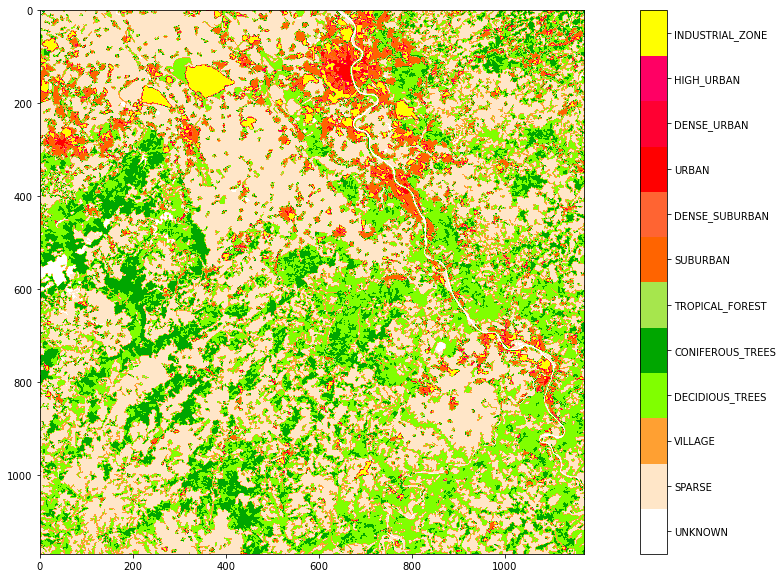

In [45]:
plt.close()
fig = plt.figure(figsize=(20, 10))
plt.imshow(clutter_data, origin='upper', cmap=cmap, norm=norm)
cbar = plt.colorbar()
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(pathprof.P452_CLUTTER_COLORS, color='k')
plt.show()

Important: the above map is not yet aligned with the SRTM grid, it just covers (about) the same area. To reproject, we can use the `scipy.optimize` functionality. As the Geotiff maps are regular and Cartesian in both dimensions (in pixel space!), a very fast method is to use the `RegularGridInterpolator`:

In [46]:
corine_interp = RegularGridInterpolator(
    (np.arange(col_width), np.arange(row_width)),
    clutter_data.T,
    method='nearest', bounds_error=True,
    )

In [47]:
clutter_data_regridded = corine_interp((corine_x - col_off, corine_y - row_off))

Now, we should put everything together into one nice function...

In [48]:
def regrid_from_geotiff(geotiff, lons, lats):

    geo_x, geo_y = wgs84_to_geotiff_pixels(geotiff, lons, lats)

    xmin, xmax = np.int32([geo_x.min(), geo_x.max()])
    ymin, ymax = np.int32([geo_y.min(), geo_y.max()])
    col_off, row_off = xmin - 5, ymin - 5
    col_width, row_width = xmax - xmin + 10, ymax - ymin + 10
    window = rio.windows.Window(col_off, row_off, col_width, row_width)

    geo_data = geotiff.read(1, window=window)


    geo_interp = RegularGridInterpolator(
        (np.arange(col_width), np.arange(row_width)),
        geo_data.T,
        method='nearest', bounds_error=True,
        )

    geo_data_regridded = geo_interp((geo_x - col_off, geo_y - row_off))
    
    return geo_data_regridded

In fact, this function is so useful, that it is also shipped in the `pycraf.pathprof` sub-package.

In [49]:
# first, close the old file handle
corine_geotiff.close()

In [50]:
# it is better to work with context managers to avoid open file handles anyway
with rio.open(CORINE_GEOTIFF) as corine_geotiff:
    corine_regridded = pathprof.regrid_from_geotiff(
        corine_geotiff, lons[np.newaxis], lats[:, np.newaxis], 
        )

In [51]:
clutter_data_regridded = pathprof.landcover_to_p452_clutter_zones(
    corine_regridded, pathprof.CORINE_TO_P452_CLASSES
    )

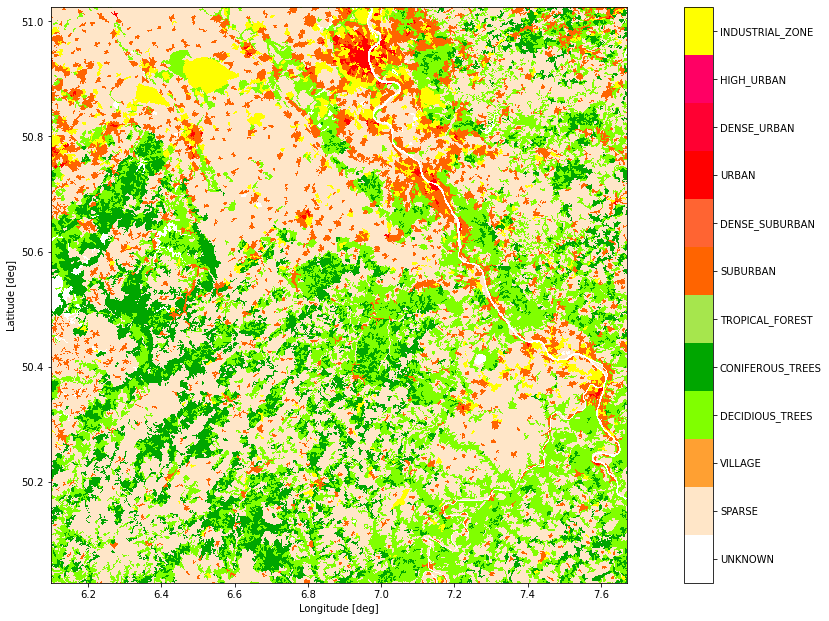

In [52]:
_lons = lons.to(u.deg).value
_lats = lats.to(u.deg).value

plt.close()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
# cbax = fig.add_axes((0.9, 0.1, 0.02, 0.7))
cim = ax.imshow(
    clutter_data_regridded, origin='lower', cmap=cmap, norm=norm,
    interpolation='nearest',
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar = plt.colorbar(cim)
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(pathprof.P452_CLUTTER_COLORS, color='k')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
plt.show()

The last step is to use this for the path propagation calculations (see [this Notebook](https://github.com/bwinkel/pycraf/blob/master/notebooks/03c_attenuation_maps.ipynb))

In [53]:
hprof_cache = pathprof.height_map_data(
    lon_tx, lat_tx,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution,
    zone_t=pathprof.CLUTTER.UNKNOWN, zone_r=pathprof.CLUTTER.UNKNOWN
    )

The returned dictionary contains a `zone_r_map` entry (remember for path loss maps, the transmitter is in the center of the map):

In [54]:
hprof_cache['zone_r_map'], hprof_cache['zone_r_map'].shape

(array([[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]], dtype=int32),
 (1201, 1201))

Before we use our clutter zone map, let's do the path loss without clutter as a reference:

In [55]:
freq = 1. * u.GHz
omega = 0. * u.percent  # fraction of path over sea
temperature = 290. * u.K
pressure = 1013. * u.hPa
timepercent = 2 * u.percent  # see P.452 for explanation
h_tg, h_rg = 50 * u.m, 1.5 * u.m
G_t, G_r = 0 * cnv.dBi, 0 * cnv.dBi

In [56]:
results = pathprof.atten_map_fast(
    freq,
    temperature,
    pressure,
    h_tg, h_rg,
    timepercent,
    hprof_cache,  # dict_like
    )

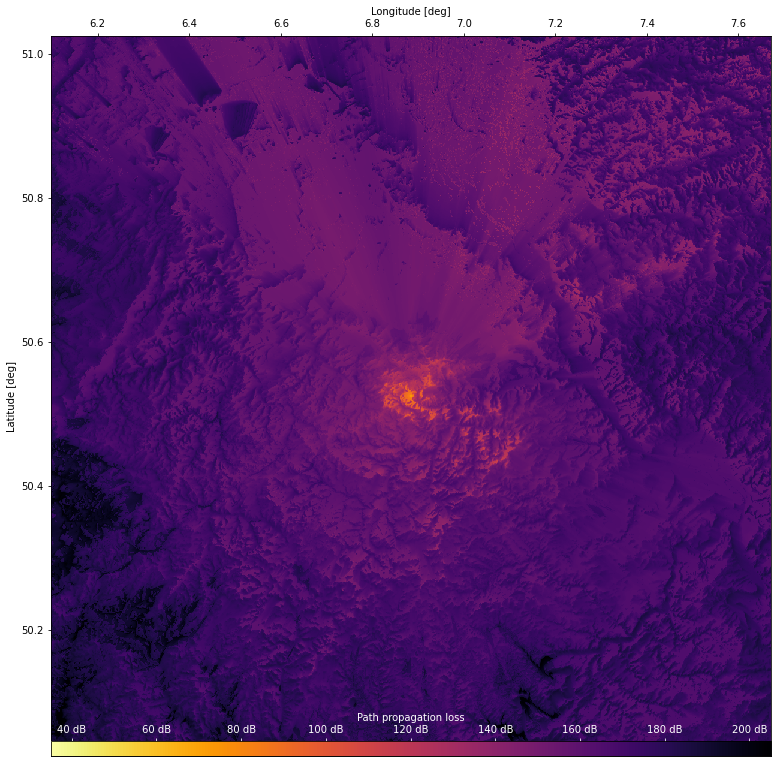

In [57]:
_lons = hprof_cache['xcoords']
_lats = hprof_cache['ycoords']
_total_atten = results['L_b_corr']  # see description of atten_map_fast

vmin, vmax = 35, 205

plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _total_atten.to(cnv.dB).value,
    origin='lower', interpolation='nearest', cmap='inferno_r',
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))

ctics = np.arange(0, vmax, 20)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
cbar.set_label(r'Path propagation loss', color='w')
cbax.xaxis.tick_top()
cbax.tick_params(axis='x', colors='w')
cbax.xaxis.set_label_position('top')

ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

Now, using the clutter map is a simple as replacing the `zone_r_map`. Mind that the regridded clutter data has a different type (float) because of the `scipy` interpolation routine. 

In [58]:
hprof_cache['zone_r_map'] = clutter_data_regridded.astype(np.int32)

In [59]:
results_with_clutter = pathprof.atten_map_fast(
    freq,
    temperature,
    pressure,
    h_tg, h_rg,
    timepercent,
    hprof_cache,  # dict_like
    )

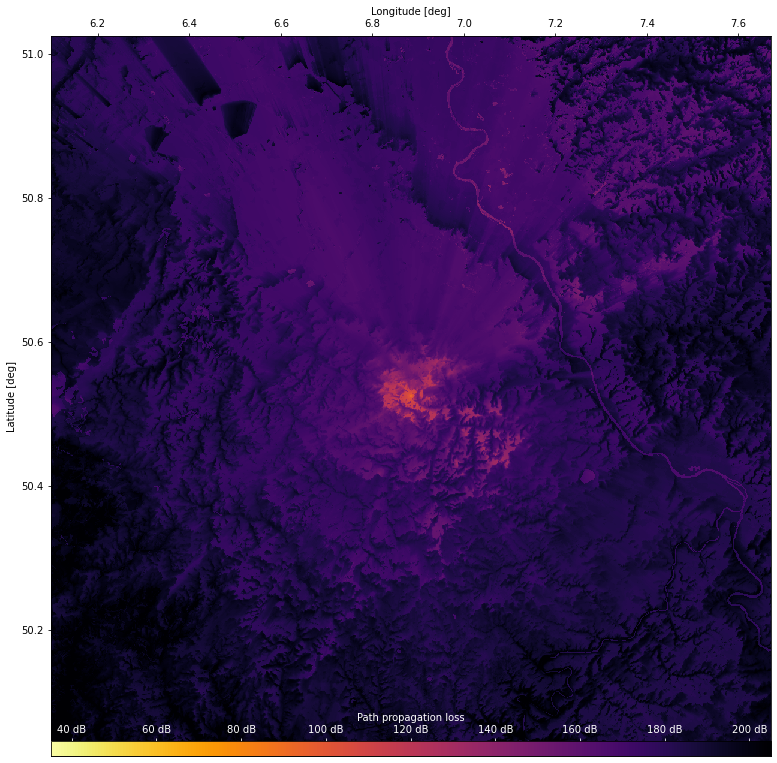

In [60]:
_lons = hprof_cache['xcoords']
_lats = hprof_cache['ycoords']
_total_atten = results_with_clutter['L_b_corr']  # see description of atten_map_fast

vmin, vmax = 35, 205

plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _total_atten.to(cnv.dB).value,
    origin='lower', interpolation='nearest', cmap='inferno_r',
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))

ctics = np.arange(0, vmax, 20)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
cbar.set_label(r'Path propagation loss', color='w')
cbax.xaxis.tick_top()
cbax.tick_params(axis='x', colors='w')
cbax.xaxis.set_label_position('top')

ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

We can also visualize the difference of the path loss with clutter w.r.t. no clutter

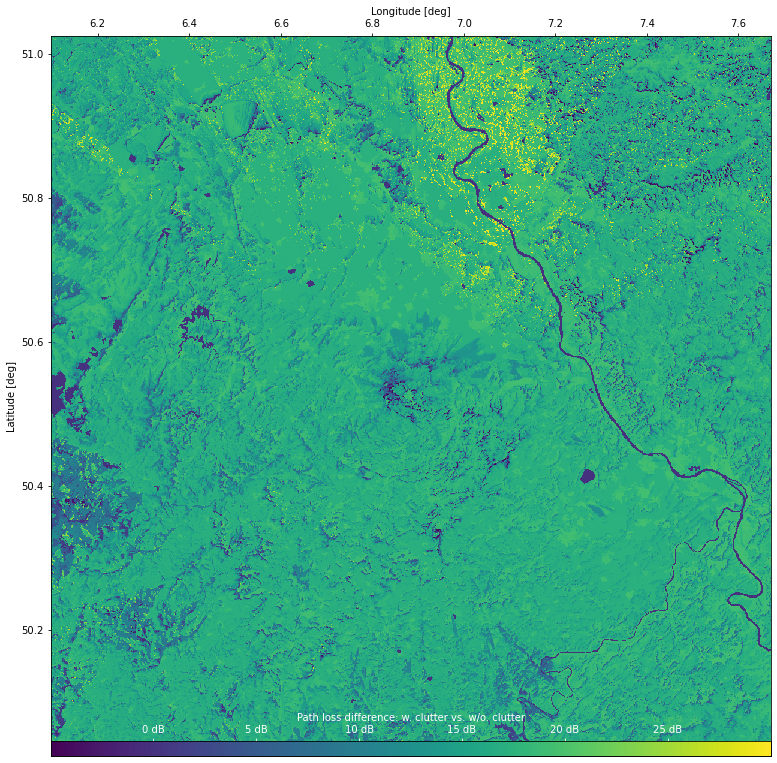

In [61]:
vmin, vmax = -5, 30

plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    (results_with_clutter['L_b_corr'] - results['L_b_corr']).value,
    origin='lower', interpolation='nearest',
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))

ctics = np.arange(0, vmax, 5)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
cbar.set_label(r'Path loss difference: w. clutter vs. w/o. clutter', color='w')
cbax.xaxis.tick_top()
cbax.tick_params(axis='x', colors='w')
cbax.xaxis.set_label_position('top')

ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

By-the-way, if you don't want to download the 200+ MB Corine GeoTiff for all of Europe, the Copernicus Server also supports the OGC/WMS (Open Geospatial Consortium Web Map Service) standard. With a suitable Python package such as OWSLib, one can query from the survey directly:

In [62]:
from owslib.wms import WebMapService

In [63]:
wms = WebMapService(
    'https://image.discomap.eea.europa.eu/arcgis/services/'
    'Corine/CLC2018_WM/MapServer/WmsServer',
    version='1.3.0'
    )
print(wms.identification.type)
print(wms.identification.version)
print(wms.identification.title)
print(wms.identification.abstract)

WMS
1.3.0
Corine Land Cover 2018
Web serice for the Corine Land Cover 2018 in web mercator projection


In [64]:
for layer in wms.contents:
    print(layer, wms[layer].title)

1 U2018_CLC2018_V2020_20u1_FR_GLP_R_WM
2 U2018_CLC2018_V2020_20u1_FR_GUF_R_WM
3 U2018_CLC2018_V2020_20u1_FR_MTQ_R_WM
4 U2018_CLC2018_V2020_20u1_FR_MYT_R_WM
5 U2018_CLC2018_V2020_20u1_FR_REU_R_WM
7 CLC2018_CLC2018_V2018_20u1_FR_GLP_WM
8 CLC2018_CLC2018_V2018_20u1_FR_Guf_WM
9 CLC2018_CLC2018_V2018_20u1_FR_MTQ_WM
10 CLC2018_CLC2018_V2018_20u1_FR_MYT_WM
11 CLC2018_CLC2018_V2018_20u1_FR_REU_WM
12 Corine Land Cover 2018 raster
13 Corine Land Cover 2018 vector


In [65]:
# layer "12" contains the raster data
print(wms['12'].boundingBoxWGS84)
print(wms['12'].crsOptions)
print(wms['12'].styles)

(-56.505142, 24.283655, 72.906158, 72.66441)
['EPSG:102100', 'CRS:84', 'EPSG:3857', 'EPSG:3035', 'EPSG:4326']
{'default': {'title': '12', 'legend': 'https://image.discomap.eea.europa.eu/arcgis/services/Corine/CLC2018_WM/MapServer/WmsServer?request=GetLegendGraphic%26version=1.3.0%26format=image/png%26layer=12', 'legend_width': '534', 'legend_height': '828', 'legend_format': 'image/png'}}


In [66]:
img = wms.getmap(
    layers=['12'],
    styles=['default'],
    srs='EPSG:4326',
    bbox=(6., 50., 7., 51.),
    size=(301, 301),
    format='image/tiff',
    )

# Write data if you want to keep it
# with open('corine.tiff', 'wb') as out:
#     out.write(img.read())


One can also retrieve the image as a jpeg:

In [67]:
img = wms.getmap(
    layers=['12'],
    styles=['default'],
    srs='EPSG:4326',
    bbox=(6., 50., 7., 51.),
    size=(301, 301),
    format='image/jpeg',
    )

In [68]:
from PIL import Image
import io

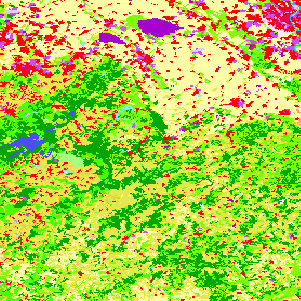

In [69]:
Image.open(io.BytesIO(img.read()))

There is also a world-wide map, based on MODIS/Terra+Aqua missions. Unfortunately, with the Web Map Service, one can only access a high-resolution dataset, which contains few regions ([MCD12Q1.006](https://lpdaac.usgs.gov/products/mcd12q1v006/)). One can download a low-res map in `hdf` format, [MCD12C1.006](https://e4ftl01.cr.usgs.gov/MOTA/MCD12C1.006/2018.01.01/), and convert it to GeoTiff with the `gdal` tools on the command line (see [Copernicus FAQ](https://land.copernicus.eu/global/faq/how-convert-swi-hdf5-data-geotiff)):

```bash
gdal_translate -a_srs "EPSG:4326" 'HDF4_EOS:EOS_GRID:"MCD12C1.A2018001.006.2019200161458.hdf":MOD12C1:Majority_Land_Cover_Type_1' MOD12C1_Majority_Land_Cover_Type_1.tiff
```

The MODIS landcover data uses the [IGBP scheme](http://www.fao.org/forestry/4031-0b6287f13b0c2adb3352c5ded18e491fd.pdf) (see Table 1). `pycraf` comes with a possible mapping, to convert IGBP to P.452 classes (`pathprof.IGBP_TO_P452_CLASSES`). The rest works as in the above example with the Corine landcover data.

In [70]:
MODIS_PATH = Path('.')  # specify path to Corine data, if not local to notebook
MODIS_GEOTIFF = MODIS_PATH / Path('MOD12C1_Majority_Land_Cover_Type_1.tiff')

In [71]:
# it is better to work with context managers to avoid open file handles anyway
with rio.open(MODIS_GEOTIFF) as modis_geotiff:
    modis_regridded = pathprof.regrid_from_geotiff(
        modis_geotiff, lons[np.newaxis], lats[:, np.newaxis], 
        )

In [72]:
clutter_data_regridded = pathprof.landcover_to_p452_clutter_zones(
    modis_regridded, pathprof.IGBP_TO_P452_CLASSES
    )

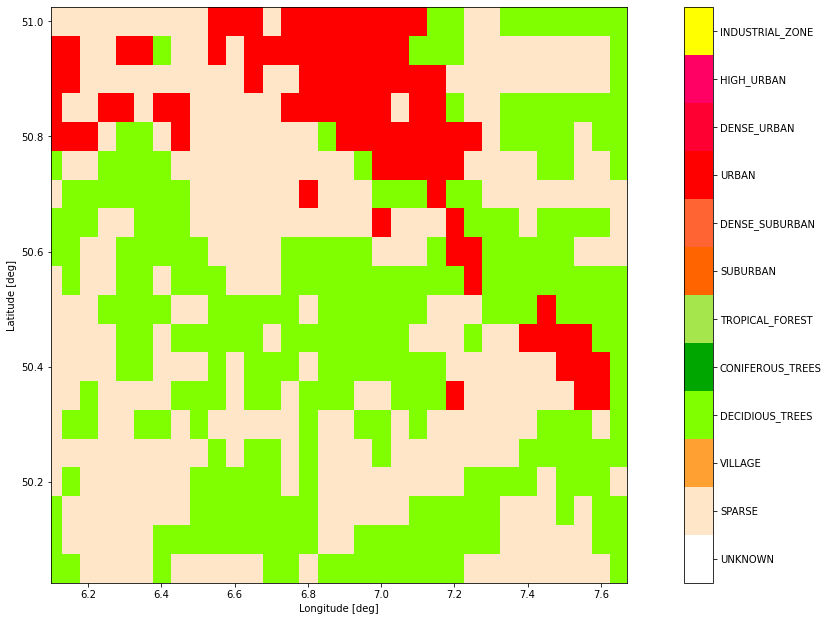

In [73]:
_lons = lons.to(u.deg).value
_lats = lats.to(u.deg).value

plt.close()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
# cbax = fig.add_axes((0.9, 0.1, 0.02, 0.7))
cim = ax.imshow(
    clutter_data_regridded, origin='lower', cmap=cmap, norm=norm,
    interpolation='nearest',
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar = plt.colorbar(cim)
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(pathprof.P452_CLUTTER_COLORS, color='k')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
plt.show()